# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [173]:
import pandas as pd
import numpy as np

In [174]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [175]:
!pip install rs-datasets

In [176]:
from rs_datasets import MovieLens

In [177]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


В моделях мы работаем с индексами объектов (в нашем случае -- фильмов), для удобства сделаем конвертацию индекса фильма в его название, для просмотра результата рекомендаций в человеко-читаемом виде.

In [178]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [179]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(8) #! the parametr represents amount of table lines

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59


Рассмотрим распределение по оценкам, которые пользователи дают фильмам. Из графика видно, что чаще всего люди дают оценки 4 или 3 (середина рейтинговой шкалы).

<BarContainer object of 5 artists>

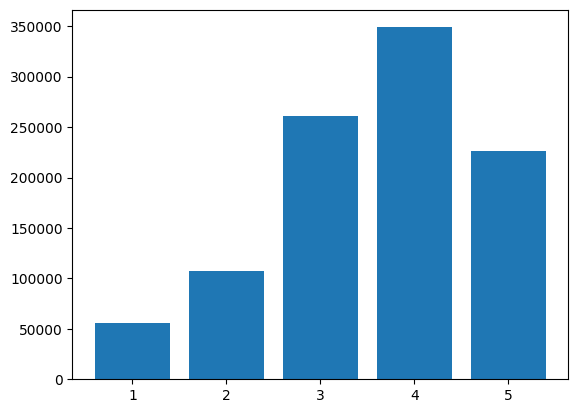

In [180]:
import matplotlib.pyplot as plt
# построим распределение оценок
grp = reviews.groupby('relevance')
marks_count = grp.size().tolist()
plt.bar(range(1, len(marks_count)+1), marks_count)

Построим график частоты оценивания фильмов -- насколько много пользователи оценивали фильмы в промежутке с 2000 по 2003 год. На графике можно четко видет два ярких пика активности. Из графика становится понятно, почему в задании просят разделить данные на тренировочную и валидационную выборки именно таким образом (данные до 1 декабря 2000 года не включая - данные train, данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные).

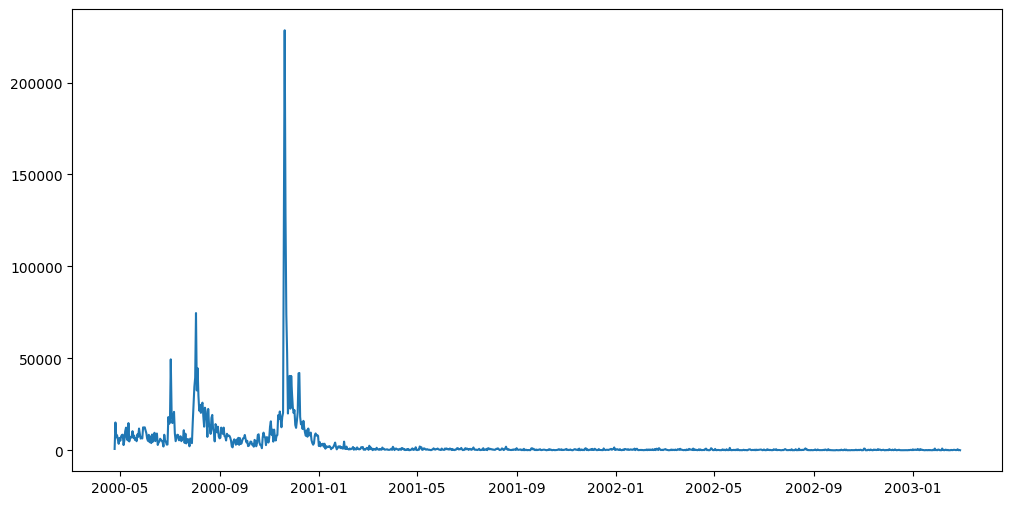

In [181]:
df = reviews.groupby(pd.Grouper(key='timestamp', axis=0,
                      freq='1D', sort=True)).sum()
plt.figure(figsize=(12, 6))
plt.plot(df['relevance'])

Заведем вспомогательную функцию для анализа квантилей оценок на пользователя и на фильм.

In [182]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

Построим график, по которому оценим, на сколько часто пользователи оценивают фильмы. По шкале абцис -- количество оценок, по оси ординат -- количество пользователей, которые ставят не более такого количество. Из графика можно сделать следующие выводы:
- все пользователи в таблице дали хотя бы 20 оценок (нет мертвых пользователей)
- в основном количество оценок, даваемое пользователем не привышает 200
- мало пользователей ставит большое количество оценок

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
5%         23.000000
25%        44.000000
50%        96.000000
75%       208.000000
95%       556.000000
max      2314.000000
Name: relevance, dtype: float64


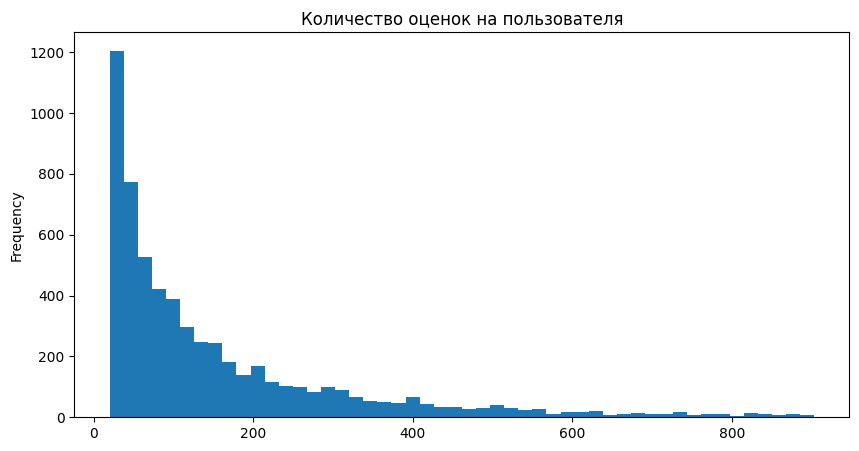

In [183]:
user_count = group_by_and_plot(reviews, group_by_name='user_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на пользователя')

Построим график, по которому оценим, на сколько часто оценивается каждый фильм.По шкале абцис -- количество оценок, по оси ординат -- фильмов, которые оцениваются не более чем таким количеством оценок. Из графика можно сделать следующие выводы:
- каждый фильм получил хотя бы по одной оценке
- в основном один фильм оценивается не более 250 раз
- мало фильмов имеет большое количество оценок

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
5%          2.000000
25%        33.000000
50%       123.500000
75%       350.000000
95%      1051.500000
max      3428.000000
Name: relevance, dtype: float64


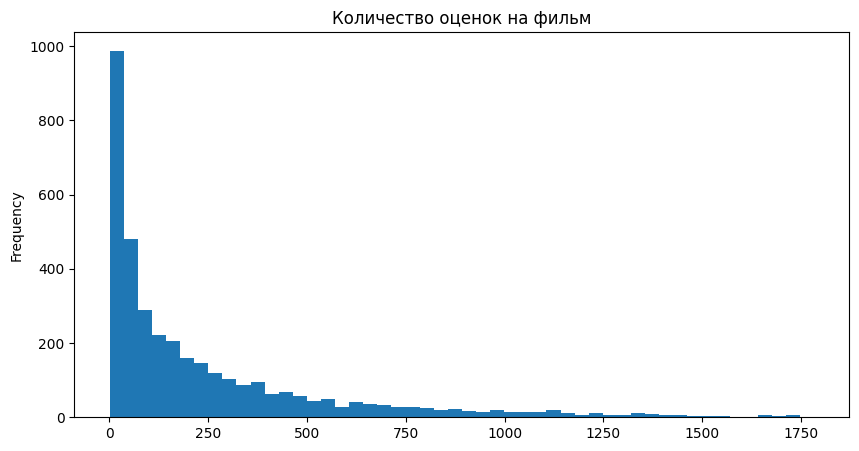

In [184]:
item_count = group_by_and_plot(reviews, group_by_name='item_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на фильм')

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

Разделим датасет на train и validation

In [185]:
train = reviews.loc[reviews['timestamp'] < '2000-12-01']
test  = reviews.loc[reviews['timestamp'] <= '2000-12-31'].loc[reviews['timestamp'] >= '2000-12-01']
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)

Train Dataset: (791270, 4)
Test Dataset: (111315, 4)


Из валидационного датасета удалим неудовлетворительные оценки. Удовлетворительными считаются оценки 4 и 5. Таким образом, в валидационном датасете остались только те пары user-item, которые имеют положительный relevance.

In [186]:
test = test[test['relevance'] > 3]
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)
test.head(10)

Train Dataset: (791270, 4)
Test Dataset: (64036, 4)


,user_id,item_id,relevance,timestamp
1205,11,1188,4,2000-12-30 23:51:59
1217,11,1198,4,2000-12-30 23:28:33
1218,11,593,5,2000-12-30 23:40:07
1226,11,1923,5,2000-12-30 23:53:13
1227,11,2580,5,2000-12-30 23:47:10
1228,11,1784,5,2000-12-30 23:45:17
1229,11,318,5,2000-12-30 23:39:07
1232,11,1358,5,2000-12-30 23:42:56
1241,11,3105,5,2000-12-30 23:41:42
1244,11,764,5,2000-12-30 23:44:29


После деления по времени в валидации могут оказаться пользователи, отсутствующие в train. Их считаем холодными (модель их не видела при обучении) и удаляем из валидационной части.

In [187]:
from tqdm import tqdm
train_users_set = set(train['user_id'].tolist())
test_users_set = set(test['user_id'].tolist())
set_intersection = train_users_set.intersection(test_users_set)

for usr in tqdm(test_users_set):
  if usr not in set_intersection:
    idx = test[test['user_id'] == usr].index
    idx.tolist()
    test = test.drop(idx.tolist())

100%|██████████| 1181/1181 [00:02<00:00, 455.53it/s]


In [188]:
# YOUR CODE HERE
train = train
val = test

In [189]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

Заведем тестового юзера, на котором будем простатривать работу моделей.

In [190]:
TEST_USER_ID = 670

Заведем вспомогательную функцию, которая позволяет посмотреть список фильмов, которые оценивал указанный пользователь, чтобы сравнить их потом с рекомендованными фильмами.

In [191]:
def get_user_group(user_id, df):
  grouped = df.groupby('user_id')
  for user_group in grouped: #! not optimal
    if user_group[1]['user_id'].tolist()[0] == user_id: #! not optimal
      return user_group
  return None

def get_user_marked_items(user_id, df):
  test_usr_group = get_user_group(user_id, df)
  assert(test_usr_group != None)
  user_marked_items_idx = test_usr_group[1]['item_id'].tolist()

  df = data.items[data.items['item_id'].isin(user_marked_items_idx)]
  return df

In [192]:
get_user_marked_items(TEST_USER_ID, val)

,item_id,title,genres
896,908,North by Northwest (1959),Drama|Thriller
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1229,1249,Nikita (La Femme Nikita) (1990),Thriller
1230,1250,"Bridge on the River Kwai, The (1957)",Drama|War
1239,1259,Stand by Me (1986),Adventure|Comedy|Drama
2555,2624,After Life (1998),Drama


In [193]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [194]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


Для каждого фильма из train предподсчитаем его среднюю оценку (понадобится далее)

In [195]:
grouped = train.groupby('item_id')
items_average_relevance = {}

for grp in grouped:
  item_idx = grp[1]['item_id'].tolist()[0] #! not optimal
  sum_relevance = grp[1]['relevance'].sum()
  relevance_count = grp[1]['relevance'].count()
  items_average_relevance[item_idx] = sum_relevance / relevance_count

## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [196]:
import random

Сгенерируем для каждого пользователя из валидационной выборки 20 рандомных рекомендаций. Так же каждой рандомной рекомендации приписываем рандомный relevance.

In [197]:
def get_n_random_items(n):
  random_items = data.items.sample(n=n, random_state=random.randint(0, 100))
  random_items_idx = random_items['item_id'].tolist()
  return random_items_idx

def make_random_pred(dataset, N):
  df = pd.DataFrame()
  for user_id in tqdm(set(dataset['user_id'].tolist())):
    random_items = get_n_random_items(N)
    for item in random_items:
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      # in this task we assume that we make a random relevance to recommended item
      new_row['relevance'] = random.randint(1, 5)
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

In [198]:
%%time
# YOUR CODE HERE
random_pred = make_random_pred(val, K)
random_pred.head(10)

100%|██████████| 522/522 [00:09<00:00, 52.79it/s]

CPU times: user 9.65 s, sys: 105 ms, total: 9.76 s
Wall time: 9.9 s


,user_id,item_id,relevance
0,2050,3348,2
0,2050,2356,5
0,2050,2641,4
0,2050,3803,2
0,2050,3734,2
0,2050,1021,2
0,2050,2485,3
0,2050,271,3
0,2050,3670,5
0,2050,3661,4


In [199]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [200]:
random_pred.head(1)

,user_id,item_id,relevance
0,2050,3348,2


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [201]:
import math

In [202]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    Reli = len(row['gt_list'])
    pred_list = row['pred_list']
    dcg = 0
    counter = 0
    for j, item in enumerate(pred_list):
      if counter >= k: break
      counter += 1
      if item in row['gt_list']:
        dcg += 1 / (math.log2(j+1+1))

    idcg = 0
    counter = 0
    for j in range(Reli):
      if counter >= k: break
      counter += 1
      idcg += 1 / (math.log2(j+1+1))

    if idcg == 0: return 0
    ndcg = dcg / idcg
    return ndcg

In [203]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [204]:
def leave_top_k(pred: pd.DataFrame,
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False)) #? if here we wan to predict the most relevance items, so we put the ascending=True
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [205]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3
def nDCG(pred, true, k):
  pred_cropped = leave_top_k(pred, k)
  # prepare score lists
  pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
  gt_grouped = true.groupby('user_id')['item_id'].apply(list).rename('gt_list')
  to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
  to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else []) # если нет оценок, записываем пустой лист (хотим сделать так, чтобы в ячейках датафрэйма лежали листы)

  sumNDCG = 0
  N = pred['user_id'].nunique()
  for _, row in to_compare.iterrows():
    sumNDCG += ndcg_user(row, k)
  return sumNDCG / N

Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [206]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        # в этом словаре мы для каждого item_id сохраним количество пользователей, которые оценивали этот item
        self.items_marks_count = {}
        self.N = log['user_id'].nunique() # число пользователей в обучающей выборке

        grouped = log.groupby('item_id')
        for grp in grouped:
          marks_count = grp[1]['user_id'].count()
          self.items_marks_count[grp[1]['item_id'].tolist()[0]] = marks_count # not optimal

    def get_item_self_info(self, item_id):
      # учитываем холодные items
      if item_id in self.items_marks_count.keys():
        return -math.log2(self.items_marks_count[item_id] / self.N)
      else:
        return -math.log2(1 / self.N)

    def __call__(self, pred, k):
        top_k_pred = leave_top_k(pred, k)
        surprisal = 0

        uniq_users_amount = top_k_pred['user_id'].nunique()
        grouped = top_k_pred.groupby('user_id')
        for grp in grouped:
          sum_self_info = grp[1]['item_id'].apply(self.get_item_self_info)
          sum_self_info = sum_self_info.sum()
          # k_marks = grp[1]['user_id'].count()
          # surprisal += sum_self_info / (math.log2(self.N) * k_marks)
          surprisal += sum_self_info / (math.log2(self.N) * k)
        return surprisal / uniq_users_amount

In [207]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

Создадим объект с предподсчитанной статистикой по тренеровочной выбоке.

In [208]:
surp = Surprisal(train)

In [209]:
from copy import deepcopy

In [210]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

def HitRate(pred, ground_truth, k):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    HR = to_compare.apply(user_hr, axis=1)
    return HR.mean()

Для каждой метрики заведем словарь. В словаре будем хранить имя модели и значение соответствующей матрики.

In [238]:
HIT_RATE = {}
COVERAGE = {}
N_DCG = {}
SURPRISAL = {}

In [239]:
COVERAGE['random'] = coverage(random_pred, K, train['item_id'].drop_duplicates())
HIT_RATE['random'] = HitRate(random_pred, val, K)
N_DCG['random'] = nDCG(random_pred, val, K)
SURPRISAL['random'] = surp(random_pred, K)

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [212]:
! pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.2 MB/s eta 0:00:00


In [213]:
import implicit

Создадим модель, которая обучается на N = 200 ближайших соседях.

In [214]:
knn_model = implicit.nearest_neighbours.CosineRecommender(200)

Внутри моделей implicit жестко захардкожены названия полей: datetime вместо timestamp, weight вместо relevance. Без этого модели выдают ошибку.

In [215]:
train.rename(columns={"timestamp": "datetime"}, inplace=True)
train.rename(columns={"relevance": "weight"}, inplace=True)

val.rename(columns={"timestamp": "datetime"}, inplace=True)
val.rename(columns={"relevance": "weight"}, inplace=True)

<ipython-input-215-976deb36a56a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"timestamp": "datetime"}, inplace=True)
<ipython-input-215-976deb36a56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"relevance": "weight"}, inplace=True)


Issue 167 в пакете implicit, необходимо привести веса к типу float, иначе метод recommend выдает ошибку.

In [216]:
val['weight'] = pd.to_numeric(val['weight'], downcast='float')
train['weight'] = pd.to_numeric(train['weight'], downcast='float')

<ipython-input-216-ee60b2884c59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight'] = pd.to_numeric(train['weight'], downcast='float')


На вход моделям из пакета implicit нужно подавать матрицу user-item. А нас изначально в датасете таблицы другого вида. Поэтому нужно имеющиеся данные преобразовать к матрице user-item.

Если формировать реальные матрицы, они будут сильно разреженные, большую часть оперативной памяти будут занимать бесполезные нули (на тех местах, где юзеры никак не взаимодействовали с обхектами). Поэтому сформируем sparse матрицы, что позволит нам оптимизировать обучение и экономить место в памяти (аналог использования списка связности вместо матрицы связности в графах).

In [217]:
from scipy.sparse import csr_matrix

# первый аргумент -- значения, содержащиеся в таблице (оценки пользователей)
# второй аргумент -- кортеж с индексами по рядам (индексы юзеров) и по столбцам (индексы объектов)
csr_train = csr_matrix((train['weight'].tolist(), (train['user_id'].tolist(), train['item_id'].tolist())))
csr_val = csr_matrix((val['weight'].tolist(), (val['user_id'].tolist(), val['item_id'].tolist())))

In [218]:
# посмотрим, как вообще это выглядит
print(csr_val)

  (670, 908)	4.0
  (670, 1248)	4.0
  (670, 1249)	4.0
  (670, 1250)	4.0
  (670, 1259)	4.0
  (670, 2624)	5.0
  (671, 29)	4.0
  (671, 34)	4.0
  (671, 41)	4.0
  (671, 101)	4.0
  (671, 111)	5.0
  (671, 260)	5.0
  (671, 300)	5.0
  (671, 471)	5.0
  (671, 589)	4.0
  (671, 858)	5.0
  (671, 908)	4.0
  (671, 923)	5.0
  (671, 954)	5.0
  (671, 1079)	4.0
  (671, 1089)	4.0
  (671, 1136)	4.0
  (671, 1196)	5.0
  (671, 1197)	4.0
  (671, 1198)	5.0
  :	:
  (5920, 1500)	4.0
  (5920, 1617)	4.0
  (5920, 1962)	4.0
  (5920, 2706)	5.0
  (5920, 3105)	5.0
  (5920, 3160)	4.0
  (5920, 3178)	5.0
  (5920, 3578)	5.0
  (5920, 3916)	5.0
  (5923, 3160)	4.0
  (5923, 3481)	4.0
  (5923, 3578)	5.0
  (5923, 3755)	4.0
  (5948, 1346)	5.0
  (5956, 2718)	4.0
  (5972, 480)	4.0
  (5972, 804)	4.0
  (5972, 1250)	4.0
  (5972, 2948)	4.0
  (5972, 3114)	5.0
  (5972, 3510)	4.0
  (5972, 3555)	4.0
  (5972, 3745)	4.0
  (5985, 2396)	4.0
  (5996, 3751)	4.0


Обучаем модель.

In [219]:
knn_model.fit(csr_train)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008348226547241211 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

Модель обучилась. Теперь можно передать ей индекс некоторого объекта и попросить выдать N наиболее похожых. Давайте попробуем это сделать.

In [220]:
#TODO: make a random valid index of item
random_item_idx = 3935
closest, scores = knn_model.similar_items(random_item_idx, N=10)
closest

array([3935, 3828, 3216,  545, 3934, 3351, 3891, 3947, 2666, 2740],
      dtype=int32)

Заведем вспомогательную функцию, которая возвращает информацию о фильмах по списку их индексов. Функцию будем использовать, чтобы сравнивать рекомендации с фильмами, которые пользователь реально оценивал.

In [221]:
def get_recommended_movies_info(items_idx_list: list):
  df = data.items[data.items['item_id'].isin(items_idx_list)]
  return df

Выведем названия фильмов

In [222]:
get_recommended_movies_info(closest)

,item_id,title,genres
541,545,Harlem (1993),Drama
2597,2666,It Conquered the World (1956),Sci-Fi
2671,2740,"Kindred, The (1986)",Horror
3147,3216,Vampyros Lesbos (Las Vampiras) (1970),Horror
3282,3351,Two Thousand Maniacs! (1964),Horror
3758,3828,Better Living (1998),Comedy
3821,3891,Turn It Up (2000),Crime|Drama
3864,3934,Kronos (1957),Sci-Fi
3865,3935,Kronos (1973),Horror
3877,3947,Get Carter (1971),Thriller


Сгенерируем рекомендации. Для отдельного пользователи получим список рекомендованных для него фильмов.

In [223]:
recommendation = knn_model.recommend(TEST_USER_ID, csr_val[TEST_USER_ID], N=10)[0]
recommendation

array([ 608,  912,  858, 1219,  919, 2858, 1617,  296, 1213, 1247],
      dtype=int32)

In [224]:
get_recommended_movies_info(recommendation)

,item_id,title,genres
293,296,Pulp Fiction (1994),Crime|Drama
604,608,Fargo (1996),Crime|Drama|Thriller
847,858,"Godfather, The (1972)",Action|Crime|Drama
900,912,Casablanca (1942),Drama|Romance|War
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
1195,1213,GoodFellas (1990),Crime|Drama
1201,1219,Psycho (1960),Horror|Thriller
1227,1247,"Graduate, The (1967)",Drama|Romance
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2789,2858,American Beauty (1999),Comedy|Drama


Сделаем вспомогательную функцию, которая принимает модель, количество запрашиваемых рекомендаций и матрицу user-item для генерации рекомендаций (передаем валидационные данные).

In [225]:
def make_recommendation_table(model, N, user_item_sparce_matrix):
  df = pd.DataFrame()
  for user_id in tqdm(set(val['user_id'].tolist())):
    # get a list of recommended items for specific user
    recommended_items = model.recommend(user_id, user_item_sparce_matrix[670], N)[0]
    for item in recommended_items:
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      new_row['relevance'] = items_average_relevance[item]
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

Сгенерируем рекомендации для всех пользователей из валидационной

In [226]:
knn_recommendations = make_recommendation_table(knn_model, K, csr_val)

100%|██████████| 522/522 [00:09<00:00, 55.33it/s]


In [227]:
knn_recommendations.head(10)

,user_id,item_id,relevance
0,2050.0,608.0,4.260726
0,2050.0,912.0,4.422351
0,2050.0,858.0,4.518538
0,2050.0,1219.0,4.227580
0,2050.0,919.0,4.237857
0,2050.0,2858.0,4.333449
0,2050.0,1617.0,4.216117
0,2050.0,296.0,4.289150
0,2050.0,1213.0,4.286545
0,2050.0,1247.0,4.236710


In [240]:
COVERAGE['knn'] = coverage(knn_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['knn'] = HitRate(knn_recommendations, val, K)
N_DCG['knn'] = nDCG(knn_recommendations, val, K)
SURPRISAL['knn'] = surp(knn_recommendations, K)

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

Построим модель ALS. TODO: написать про параметры.

In [229]:
als_model = implicit.als.AlternatingLeastSquares(factors=32, random_state=42, num_threads=4)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Обучаем модель на тренеровочной модели usr-item

In [230]:
als_model.fit(csr_train)

  0%|          | 0/15 [00:00<?, ?it/s]

In [231]:
#TODO: make a random valid index of item
random_item_idx = 3935
closest, scores = knn_model.similar_items(random_item_idx, N=10)
closest

array([3935, 3828, 3216,  545, 3934, 3351, 3891, 3947, 2666, 2740],
      dtype=int32)

In [232]:
get_recommended_movies_info(closest)

,item_id,title,genres
541,545,Harlem (1993),Drama
2597,2666,It Conquered the World (1956),Sci-Fi
2671,2740,"Kindred, The (1986)",Horror
3147,3216,Vampyros Lesbos (Las Vampiras) (1970),Horror
3282,3351,Two Thousand Maniacs! (1964),Horror
3758,3828,Better Living (1998),Comedy
3821,3891,Turn It Up (2000),Crime|Drama
3864,3934,Kronos (1957),Sci-Fi
3865,3935,Kronos (1973),Horror
3877,3947,Get Carter (1971),Thriller


In [233]:
recommendation = als_model.recommend(TEST_USER_ID, csr_val[TEST_USER_ID], N=10)[0]
recommendation

array([ 923,  912, 1193,  919,  904, 1252, 1230,  903, 1247, 1219],
      dtype=int32)

In [234]:
get_recommended_movies_info(recommendation)

,item_id,title,genres
891,903,Vertigo (1958),Mystery|Thriller
892,904,Rear Window (1954),Mystery|Thriller
900,912,Casablanca (1942),Drama|Romance|War
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
911,923,Citizen Kane (1941),Drama
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1201,1219,Psycho (1960),Horror|Thriller
1211,1230,Annie Hall (1977),Comedy|Romance
1227,1247,"Graduate, The (1967)",Drama|Romance
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller


In [235]:
als_recommendations = make_recommendation_table(als_model, K, csr_val)

100%|██████████| 522/522 [00:14<00:00, 35.35it/s]


In [236]:
als_recommendations.head(10)

,user_id,item_id,relevance
0,2050.0,3408.0,3.900948
0,2050.0,3160.0,3.895556
0,2050.0,2858.0,4.333449
0,2050.0,2336.0,4.029372
0,2050.0,2433.0,3.368530
0,2050.0,2716.0,3.897521
0,2050.0,2908.0,4.046921
0,2050.0,2688.0,3.170557
0,2050.0,2396.0,4.116903
0,2050.0,2333.0,3.793177


In [241]:
COVERAGE['als'] = coverage(als_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['als'] = HitRate(als_recommendations, val, K)
N_DCG['als'] = nDCG(als_recommendations, val, K)
SURPRISAL['als'] = surp(als_recommendations, K)

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Вспомогательная функция для отрисовки графиков.

In [249]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, round(y, 5), ha='center')

Для каждой из 4 метрик качества: coverage, hit rate, DCG и surprisal построим сравнительные графики для 3 методов предсказаний.

Text(0.5, 1.0, 'SURPRISAL')

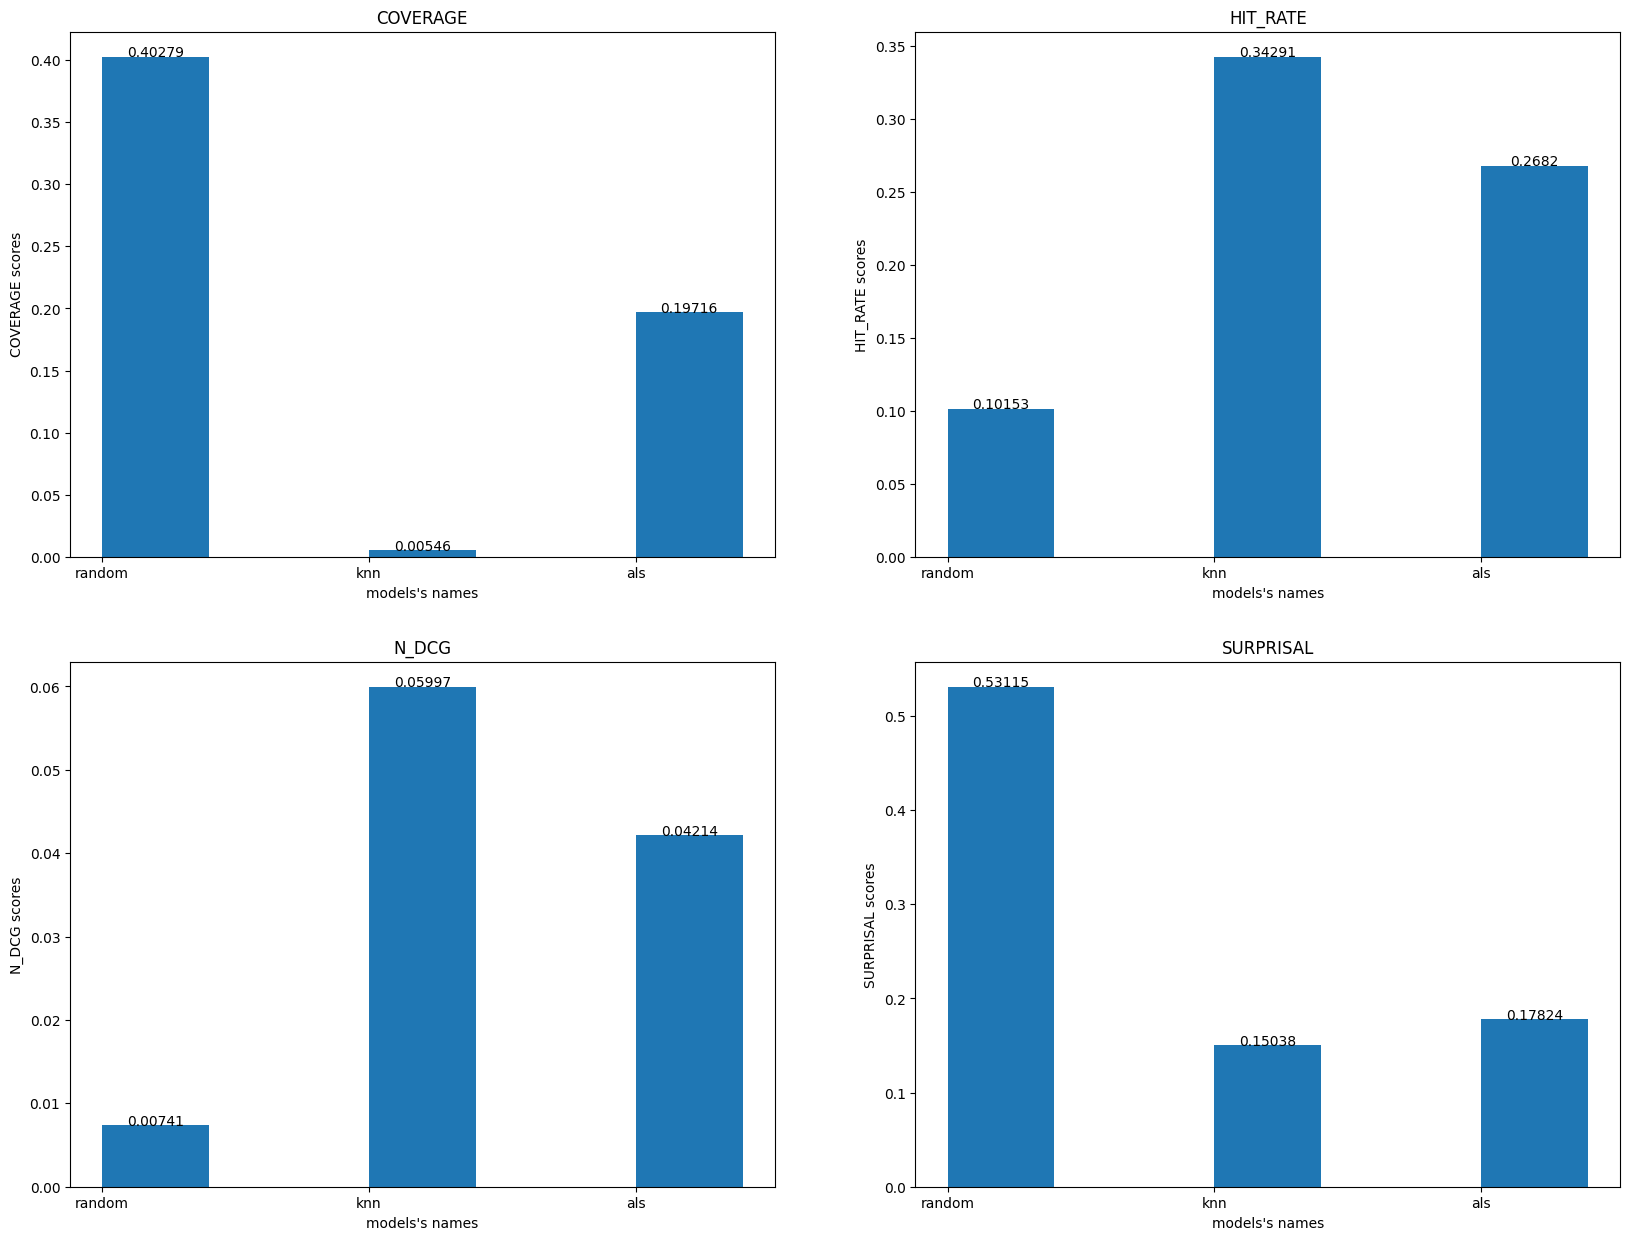

In [250]:
models_names = COVERAGE.keys()

# make x labels for bar plot + some magic for plot view
x_ticks = np.arange(0, len(models_names)*5, 5)
standart_width = 2


plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.bar(x_ticks + standart_width/2, COVERAGE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, COVERAGE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("COVERAGE scores")
plt.title(f"COVERAGE")

plt.subplot(2,2,2)
plt.bar(x_ticks + standart_width/2, HIT_RATE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, HIT_RATE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("HIT_RATE scores")
plt.title(f"HIT_RATE")

plt.subplot(2,2,3)
plt.bar(x_ticks + standart_width/2, N_DCG.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, N_DCG.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("N_DCG scores")
plt.title(f"N_DCG")

plt.subplot(2,2,4)
plt.bar(x_ticks + standart_width/2, SURPRISAL.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, SURPRISAL.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("SURPRISAL scores")
plt.title(f"SURPRISAL")

Проанализируем полученные результаты. Для начала разберем, в чем состоит сокральный смысл каждой из метрик.
- Surprisal -- показввает, насколько рекомендованные объекты хороши для пользователя с точки зрения "новизны". Скажем, чем больше значение surprisal, тем более рекомендованные объекты являются "уникальными".
- Coverage -- показывает, как много объектов из обучающей выборки используется для рекомендаций. Если coverage маленький, то система рекомендует всем пользователям одни и те же объекты из малого подмножества. Если coverage большой -- система охватывает широкий спектр рекомендуемых пользователю объектов.
- nDCG -- оценивает точность рекомендаций + учитывает порядок расположения объектов в списке рекомендаций.
- Hit rate -- показывает процент релевантных товаров. То есть, какой процент товаров из рекомендованных пользователь реально приобрел.

Сделаем некоторые выводы по наблюдаемым результатам и проделанной работе:
- На примере тестового пользователя можно видеть результат работы каждой ил рекомендательных моделей. Можно посмотреть на список фильмов, просмотренных пользователем, а затем на список рекомендованных ему фильмов. Самый простой способ понять а работает ли вообще рекомендательная модель -- сравнить жанры просмотренных и рекомендованных фильмов. Видно что более менее жанры совпадают, а значит, рекомендательные можели выучили некоторорые зависимоти (довольно логично, что, как правило, конкретный человек предпочитает фильмы конкретных данров).

О трудностях, возникших при выполнении работы.

Библиотека implicit -- основная трудность при выполнении этой работы. Я буду максимально откровенен в своем фидбеке, на сколько это возможно в рамках цензурной лексики. Хотя, тут претензии скорее к разработчикам этой библиотеки. Докуменнтация к ней просто ужасна. Фактически, ее нет. Все, что есть в официальной документации -- максимально краткое описание классов (нет, серьезно, там описания БУКВАЛЬНО в одну строчку), которое и так очевидно следует из названия этого самого класса. Нет ни нормальных описаний методов, ни описаний принимаемых параметров, ни, тем более, примеров использования. С примерами вообще очень тяжко. Мне не удалось найти практически ничего в интернете, ни на kagle и нигде (почему отсутствие примеров это очень больно -- будет понятно дальше).
Таким образом, пришлось лезть в исходные коды библиотеки (чего я как пользователь, по моему личному субъективному мнению делать не должен). И даже на этом цирк не кончается. При правильном, корректном использовании методов, вылезали ошибки, исправить которые удалось, только почитав issues в репозитории той же библиотеки (я даже в работе сослался на конкретный issue в одном месте + вот почему отсутствие примеров использования -- это боль).